In [3]:
import ipywidgets as widgets
from IPython.display import display
import plotly.express as px
import webbrowser
import random
import regex
from pymongo import MongoClient
import pandas as pd
import re
from collections import Counter
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import hdbscan
from sklearn.metrics.pairwise import cosine_similarity
#import fasttext


**Nuskaitome duomenis iš MongoDB**

In [ ]:
client = MongoClient("mongodb://localhost:27017/") 
db = client["kursinis"] 
collection = db["data"]  

file_path = "mif_translation_task_sample.parquet"
df = pd.read_parquet(file_path, engine="pyarrow")

print(df.head())
df = df.apply(lambda col: col.map(lambda x: str(x).encode('utf-8', 'ignore').decode('utf-8') if isinstance(x, str) else x))

data_dict = df.to_dict(orient="records")

# Insert data into MongoDB
#collection.insert_many(data_dict)

print("Data successfully uploaded to MongoDB!")

  retailer country_name   field_name    field_id  \
0    Jumia      Algeria         name   705807912   
1    Jumia      Algeria         name   598369000   
2    Jumia      Algeria         name   599842971   
3    Jumia      Algeria         name   894945323   
4    Jumia      Algeria  description  1112049011   

                                         field_value language_code  
0       Babyliss SÈCHE-CHEVEUX POWER DRY 2100 D563DE            fr  
1  Issey Miyake Eau De Toilette Intense - L' Eau ...            fr  
2    BRILEX NETTOYANT DÉGRAISSANT AU VINAIGRE 650 ML            fr  
3  Philips Tondeuse homme One Blade Pro 360 QP654...            fr  
4  ## Détails \nLa\ntondeuse à barbe King C. Gill...            fr  
Data successfully uploaded to MongoDB!


**Grafikai**

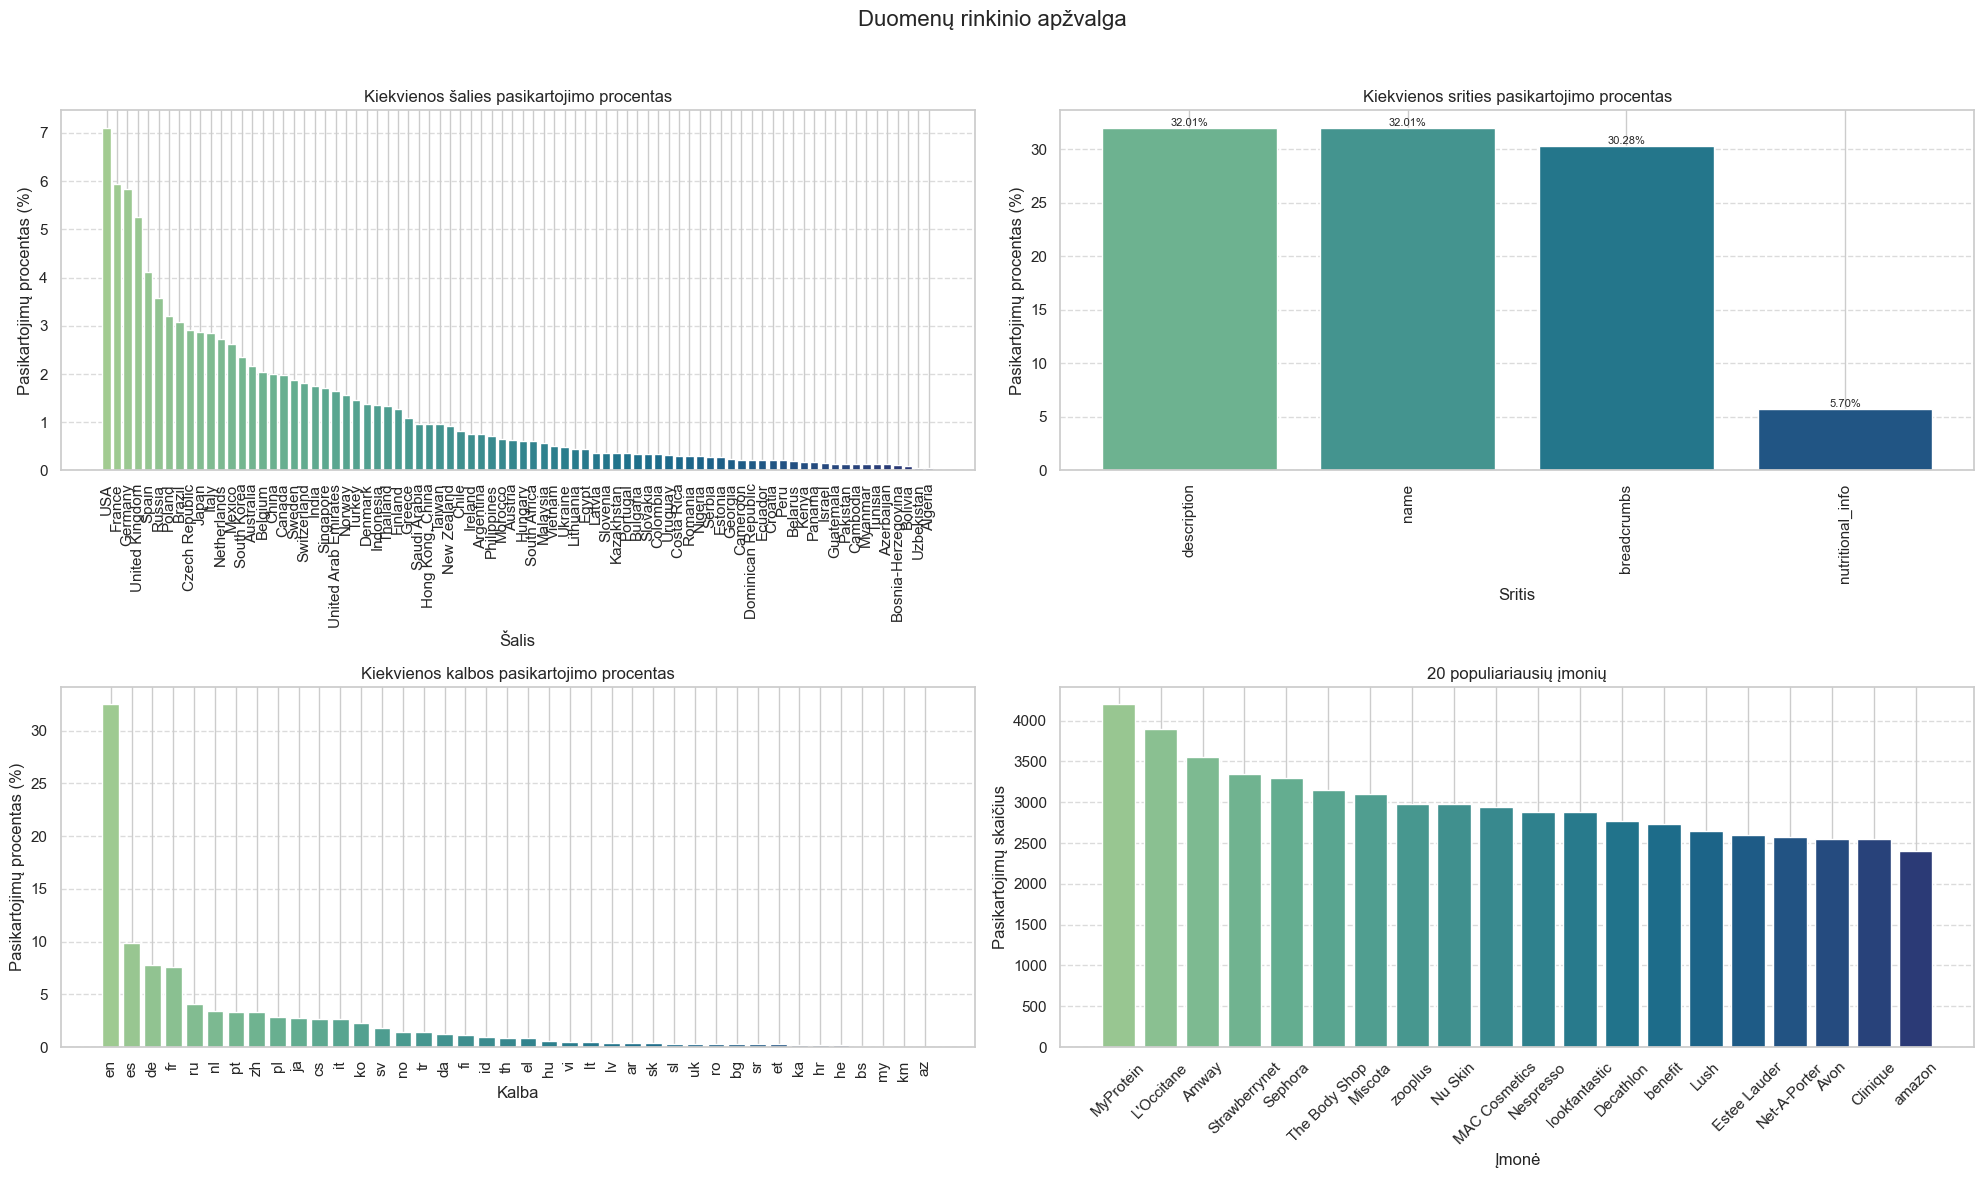

In [ ]:
country_percentages = df['country_name'].value_counts(normalize=True) * 100
sorted_countries = country_percentages.sort_values(ascending=False)

field_percentages = df['field_name'].value_counts(normalize=True) * 100
sorted_fields = field_percentages.sort_values(ascending=False)

language_percentages = df['language_code'].value_counts(normalize=True) * 100
sorted_language = language_percentages.sort_values(ascending=False)

top_20_retailers = df['retailer'].value_counts().head(20)


sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle("Duomenų rinkinio apžvalga", fontsize=16)

# 1. Šalių procentai
axs[0, 0].bar(sorted_countries.index, sorted_countries.values, color=sns.color_palette("crest", len(sorted_countries)))
axs[0, 0].set_title("Kiekvienos šalies pasikartojimo procentas")
axs[0, 0].set_xlabel("Šalis")
axs[0, 0].set_ylabel("Pasikartojimų procentas (%)")
axs[0, 0].tick_params(axis='x', rotation=90)
axs[0, 0].grid(axis='y', linestyle='--', alpha=0.7)

# 2. Sritys
bars = axs[0, 1].bar(sorted_fields.index, sorted_fields.values, color=sns.color_palette("crest", len(sorted_fields)))
axs[0, 1].set_title("Kiekvienos srities pasikartojimo procentas")
axs[0, 1].set_xlabel("Sritis")
axs[0, 1].set_ylabel("Pasikartojimų procentas (%)")
axs[0, 1].tick_params(axis='x', rotation=90)
axs[0, 1].grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    height = bar.get_height()
    axs[0, 1].text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}%', 
                  ha='center', va='bottom', fontsize=8)

# 3. Kalbos
axs[1, 0].bar(sorted_language.index, sorted_language.values, color=sns.color_palette("crest", len(sorted_language)))
axs[1, 0].set_title("Kiekvienos kalbos pasikartojimo procentas")
axs[1, 0].set_xlabel("Kalba")
axs[1, 0].set_ylabel("Pasikartojimų procentas (%)")
axs[1, 0].tick_params(axis='x', rotation=90)
axs[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# 4. Įmonės
axs[1, 1].bar(top_20_retailers.index, top_20_retailers.values, color=sns.color_palette("crest", len(top_20_retailers)))
axs[1, 1].set_title("20 populiariausių įmonių")
axs[1, 1].set_xlabel("Įmonė")
axs[1, 1].set_ylabel("Pasikartojimų skaičius")
axs[1, 1].tick_params(axis='x', rotation=45)
axs[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
lang_country_counts = df.groupby(["country_name", "language_code"]).size().unstack(fill_value=0)

country_dropdown = widgets.Dropdown(
    options=lang_country_counts.index,
    description="Šalis:",
    style={'description_width': 'initial'}
)

def plot_language_distribution(selected_country):
    plt.figure(figsize=(10, 5))
    lang_counts = lang_country_counts.loc[selected_country]

    data = lang_counts.reset_index()
    data.columns = ['language_code', 'count']
    data['percentage'] = (data['count'] / data['count'].sum()) * 100

    ax = sns.barplot(
        data=data,
        x='language_code',
        y='percentage',
        hue='language_code',
        palette='crest',
        legend=False
    )

    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.1f}%',
                        (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom', fontsize=10, color='black')

    plt.xlabel("Kalbos kodas")
    plt.ylabel("Procentai (%)")
    plt.title(f"Kalbos kodų pasiskirstymas šalyje „{selected_country}“")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

widgets.interactive(plot_language_distribution, selected_country=country_dropdown)



interactive(children=(Dropdown(description='Šalis:', options=('Algeria', 'Argentina', 'Australia', 'Austria', …

In [ ]:
lang_retailer_counts = df.groupby(["retailer", "language_code"]).size().unstack(fill_value=0)

retailer_dropdown = widgets.Dropdown(
    options=lang_retailer_counts.index,
    description="Mažmeninkas:",
    style={'description_width': 'initial'}
)

def plot_language_distribution(selected_retailer):
    plt.figure(figsize=(10, 5))
    lang_counts = lang_retailer_counts.loc[selected_retailer]

    data = lang_counts.reset_index()
    data.columns = ['language_code', 'count']
    data['percentage'] = (data['count'] / data['count'].sum()) * 100

    ax = sns.barplot(
        data=data,
        x='language_code',
        y='percentage',
        hue='language_code',  
        palette='crest',
        legend=False 
    )

    for p in ax.patches:
        if p.get_height() > 0:
            ax.annotate(f'{p.get_height():.1f}%',
                        (p.get_x() + p.get_width() / 2, p.get_height()),
                        ha='center', va='bottom', fontsize=10, color='black')

    plt.xlabel("Kalbos kodas")
    plt.ylabel("Procentai (%)")
    plt.title(f"Kalbos kodų pasiskirstymas mažmeninko „{selected_retailer}“ puslapiuose")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

widgets.interactive(plot_language_distribution, selected_retailer=retailer_dropdown)


interactive(children=(Dropdown(description='Mažmeninkas:', options=('1-2-3 TV', '1001 Kahve', '1001 Pharmacies…

In [ ]:
country_counts = df['country_name'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

crest_palette = sns.color_palette("crest", as_cmap=False, n_colors=10).as_hex()

fig = px.choropleth(
    country_counts,
    locations='country',
    locationmode='country names',
    color='count',
    color_continuous_scale=crest_palette,
    title='Duomenų pasiskirstymas šalyse',
    labels={'count': 'Įrašų skaičius', 'country': 'Šalis'}
)

fig.write_html("country_map.html")
webbrowser.open("country_map.html")


True

**Top žodžių radimas, bei teksto valymas**

In [ ]:
# Function to extract clean words
def extract_clean_words(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  
    words = re.findall(r'\b[a-zA-Z]+\b', text.lower())  
    return words  

query = {"country_name": "Germany"}

field_values = [doc["field_value"] for doc in collection.find(query) if "field_value" in doc]

all_words = []  
for text in field_values:
    all_words.extend(extract_clean_words(text))

word_counts = Counter(all_words)

top_5_words = word_counts.most_common(10)

print("Dažniausiai pasitaikantys žodžiai vokiškuose tekstuose:")
for word, count in top_5_words:
    print(f"{word}: {count}")


Dažniausiai pasitaikantys žodžiai vokiškuose tekstuose:
und: 26685
die: 17702
g: 15479
der: 13369
mit: 11141
in: 10112
fr: 9855
von: 7503
sie: 7232
das: 6583


In [ ]:
data = collection.find({}, {
    "_id":1,
    "retailer": 1,
    "country_name": 1,
    "field_name": 1,
    "field_id": 1,
    "field_value": 1,
    "language_code": 1
})

df = pd.DataFrame(list(data))

**Lyginame fasttext ir MBert**

In [ ]:
model = fasttext.load_model('cc.ml.300.bin')

def get_sentence_embedding(sentence, model):
    return model.get_sentence_vector(sentence)

sentence_pairs = [
    ("Very tasty natural meat from Lithuania with seasoning from uncles farm",
     "Labai skani natūrali mėsa iš Lietuvos su marinatu iš dėdės ūkio"),

    ("Fresh organic milk from local cows, bottled the same day.",
     "Šviežias ekologiškas pienas iš vietinių karvių, išpilstytas tą pačią dieną."),

    ("Crispy rye bread baked in a traditional wood-fired oven.",
     "Traški ruginė duona, kepta tradicinėje krosnyje kūrenamoje malkomis."),

    ("Sweet apples picked from our family orchard this morning.",
     "Saldūs obuoliai, nuskinti šį rytą iš mūsų šeimos sodo."),

    ("Delicious homemade cheese aged for 3 months in the cellar.",
     "Skanus naminis sūris, brandintas 3 mėnesius rūsyje."),

    ("Natural forest honey harvested from wild Lithuanian bees.",
     "Natūralus miško medus, surinktas iš laukinių Lietuvos bičių."),

    ("Traditional potato pancakes with sour cream and herbs.",
     "Tradiciniai bulviniai blynai su grietine ir žolelėmis."),

    ("Juicy strawberries grown without pesticides in clean soil.",
     "Sultingos braškės, užaugintos be pesticidų švarioje dirvoje."),

    ("Smoked sausage made following a hundred-year-old family recipe.",
     "Rūkyta dešra pagal šimtmečio senumo šeimos receptą."),

    ("Freshly churned butter made from local farm cream.",
     "Šviežiai plakta sviestas iš vietinio ūkio grietinėlės.")
]

similarities = []
for i, (sent_en, sent_lt) in enumerate(sentence_pairs, 1):
    emb_en = get_sentence_embedding(sent_en, model)
    emb_lt = get_sentence_embedding(sent_lt, model)
    similarity = cosine_similarity([emb_en], [emb_lt])[0][0]
    similarities.append(similarity)
    print(f"{i:2d}. Kosinuso panašumo rodiklis, Fasttext: {similarity:.4f}")
    print(f"    EN: {sent_en}")
    print(f"    LT: {sent_lt}\n")

average_similarity = sum(similarities) / len(similarities)
print(f"Vidutinė panašumo reikšmė, Fasttext: {average_similarity:.4f}")




 1. Kosinuso panašumo rodiklis, Fasttext: 0.5919
    EN: Very tasty natural meat from Lithuania with seasoning from uncles farm
    LT: Labai skani natūrali mėsa iš Lietuvos su marinatu iš dėdės ūkio

 2. Kosinuso panašumo rodiklis, Fasttext: 0.6705
    EN: Fresh organic milk from local cows, bottled the same day.
    LT: Šviežias ekologiškas pienas iš vietinių karvių, išpilstytas tą pačią dieną.

 3. Kosinuso panašumo rodiklis, Fasttext: 0.6244
    EN: Crispy rye bread baked in a traditional wood-fired oven.
    LT: Traški ruginė duona, kepta tradicinėje krosnyje kūrenamoje malkomis.

 4. Kosinuso panašumo rodiklis, Fasttext: 0.6040
    EN: Sweet apples picked from our family orchard this morning.
    LT: Saldūs obuoliai, nuskinti šį rytą iš mūsų šeimos sodo.

 5. Kosinuso panašumo rodiklis, Fasttext: 0.6245
    EN: Delicious homemade cheese aged for 3 months in the cellar.
    LT: Skanus naminis sūris, brandintas 3 mėnesius rūsyje.

 6. Kosinuso panašumo rodiklis, Fasttext: 0.6530
  

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name).to(device)
model.eval()

def get_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

sentence_pairs = [
    ("Very tasty natural meat from Lithuania with seasoning from uncles farm",
     "Labai skani natūrali mėsa iš Lietuvos su marinatu iš dėdės ūkio"),

    ("Fresh organic milk from local cows, bottled the same day.",
     "Šviežias ekologiškas pienas iš vietinių karvių, išpilstytas tą pačią dieną."),

    ("Crispy rye bread baked in a traditional wood-fired oven.",
     "Traški ruginė duona, kepta tradicinėje krosnyje kūrenamoje malkomis."),

    ("Sweet apples picked from our family orchard this morning.",
     "Saldūs obuoliai, nuskinti šį rytą iš mūsų šeimos sodo."),

    ("Delicious homemade cheese aged for 3 months in the cellar.",
     "Skanus naminis sūris, brandintas 3 mėnesius rūsyje."),

    ("Natural forest honey harvested from wild Lithuanian bees.",
     "Natūralus miško medus, surinktas iš laukinių Lietuvos bičių."),

    ("Traditional potato pancakes with sour cream and herbs.",
     "Tradiciniai bulviniai blynai su grietine ir žolelėmis."),

    ("Juicy strawberries grown without pesticides in clean soil.",
     "Sultingos braškės, užaugintos be pesticidų švarioje dirvoje."),

    ("Smoked sausage made following a hundred-year-old family recipe.",
     "Rūkyta dešra pagal šimtmečio senumo šeimos receptą."),

    ("Freshly churned butter made from local farm cream.",
     "Šviežiai plakta sviestas iš vietinio ūkio grietinėlės.")
]

similarities = []
for i, (sent_en, sent_lt) in enumerate(sentence_pairs, 1):
    emb_en = get_embeddings([sent_en])[0]
    emb_lt = get_embeddings([sent_lt])[0]
    similarity = cosine_similarity([emb_en], [emb_lt])[0][0]
    similarities.append(similarity)
    print(f"{i:2d}. Kosinuso panašumo rodiklis, mBert: {similarity:.4f}")
    print(f"    EN: {sent_en}")
    print(f"    LT: {sent_lt}\n")

average_similarity = sum(similarities) / len(similarities)
print(f"Vidutinė panašumo reikšmė mBert: {average_similarity:.4f}")


 1. Kosinuso panašumo rodiklis, mBert: 0.8247
    EN: Very tasty natural meat from Lithuania with seasoning from uncles farm
    LT: Labai skani natūrali mėsa iš Lietuvos su marinatu iš dėdės ūkio

 2. Kosinuso panašumo rodiklis, mBert: 0.7490
    EN: Fresh organic milk from local cows, bottled the same day.
    LT: Šviežias ekologiškas pienas iš vietinių karvių, išpilstytas tą pačią dieną.

 3. Kosinuso panašumo rodiklis, mBert: 0.8301
    EN: Crispy rye bread baked in a traditional wood-fired oven.
    LT: Traški ruginė duona, kepta tradicinėje krosnyje kūrenamoje malkomis.

 4. Kosinuso panašumo rodiklis, mBert: 0.3426
    EN: Sweet apples picked from our family orchard this morning.
    LT: Saldūs obuoliai, nuskinti šį rytą iš mūsų šeimos sodo.

 5. Kosinuso panašumo rodiklis, mBert: 0.8866
    EN: Delicious homemade cheese aged for 3 months in the cellar.
    LT: Skanus naminis sūris, brandintas 3 mėnesius rūsyje.

 6. Kosinuso panašumo rodiklis, mBert: 0.8084
    EN: Natural fore

**Embeddingai**

In [ ]:
'''
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) 
model.half() 

def get_embeddings(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt").to(device)  
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()


df_sample = df.iloc[:]
field_values = df_sample["field_value"].astype(str).tolist()

batch_size = 32  
all_embeddings = []

for i in range(0, len(field_values), batch_size):
    batch_texts = field_values[i : i + batch_size] 
    batch_embeddings = get_embeddings(batch_texts)  
    print(i)
    all_embeddings.append(batch_embeddings)

embeddings = torch.cat([torch.tensor(batch) for batch in all_embeddings]).numpy()

embeddings_df = pd.DataFrame(embeddings, columns=[f"emb_{i}" for i in range(embeddings.shape[1])])
df_final = pd.concat([df_sample[["_id", "retailer", "country_name", "field_name", "field_id", "language_code"]], embeddings_df], axis=1)

df_final.to_csv("embedded_data_all.csv", index=False)
'''

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

c:\Users\Dell\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Dell\.cache\huggingface\hub\models--bert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

KeyboardInterrupt: 

In [ ]:
'''
model = fasttext.load_model("cc.ml.300.bin")

df_sample = df.iloc[:]
field_values = df_sample["field_value"].astype(str).tolist()

batch_size = 32
all_embeddings = []

def get_fasttext_embeddings(texts):
    clean_texts = [text.replace('\n', ' ').replace('\r', ' ') for text in texts]
    return [model.get_sentence_vector(text).astype(np.float16) for text in clean_texts]

for i in range(0, len(field_values), batch_size):
    batch_texts = field_values[i : i + batch_size]
    batch_embeddings = get_fasttext_embeddings(batch_texts)
    print(f"Processed {i} rows")
    all_embeddings.append(batch_embeddings)

embeddings = np.vstack(all_embeddings).astype(np.float16)

embeddings_df = pd.DataFrame(embeddings, columns=[f"emb_{i}" for i in range(embeddings.shape[1])])
df_final = pd.concat([df_sample[["_id", "retailer", "country_name", "field_name", "field_id", "language_code"]].reset_index(drop=True), embeddings_df], axis=1)

df_final.to_csv("embedded_data_fasttext_all_fp16.csv", index=False)
'''


In [ ]:
#df = pd.read_csv("embedded_data_fasttext_all_fp16.csv")
#embedding_cols = [col for col in df.columns if col.startswith("emb_")]
#df[embedding_cols] = df[embedding_cols].astype(np.float16)
#df.to_parquet("embedded_data_fasttext_optimized.parquet", index=False)

#print("Clean parquet file saved.")

**Skirstome į regionus ir sub-regionus**

In [ ]:
df_regions = pd.read_csv("UNSD — Methodology.csv", delimiter=";", on_bad_lines="skip")
df_bert = pd.read_parquet("embedded_data_all_optimized.parquet", engine="pyarrow")
df_fasttext= pd.read_parquet("embedded_data_fasttext_optimized.parquet", engine="pyarrow")

In [ ]:
df_regions_trimmed = df_regions[["Country or Area", "Region Code", "Sub-region Code"]]

df_merged_bert = df_bert.merge(
    df_regions_trimmed,
    how="left",
    left_on="country_name",
    right_on="Country or Area"
)

df_merged_bert = df_merged_bert.drop(columns=["Country or Area"])

df_merged_fasttext = df_fasttext.merge(
    df_regions_trimmed,
    how="left",
    left_on="country_name",
    right_on="Country or Area"
)

df_merged_fasttext = df_merged_fasttext.drop(columns=["Country or Area"])

In [ ]:
def split_by_region_code(df):
    """
    Splits a DataFrame into separate DataFrames based on region codes.
    It also handles rows with missing region codes and returns the unmatched countries.

    Parameters:
    - df: The input DataFrame that contains the "Region Code" column.

    Returns:
    - region_dfs: A dictionary where keys are region names and values are DataFrames for each region.
    - missing_region_df: DataFrame containing rows with missing "Region Code".
    - unmatched_countries: List of countries with missing region codes.
    """
    
    region_codes = {
        2: "Afrika",
        19: "Amerikos",
        150: "Europa",
        142: "Azija",
        9: "Okeanija"
    }

    region_dfs = {}

    for code, name in region_codes.items():
        region_dfs[name] = df[
            (df["Region Code"] == code)
        ]
    
    missing_region = df[df["Region Code"].isnull()]

    unique_missing_countries = missing_region["country_name"].dropna().unique()

    return region_dfs, missing_region, unique_missing_countries

region_dfs_bert, missing_region_bert, unmatched_countries_bert = split_by_region_code(df_merged_bert)
region_dfs_fasttext, missing_region_fasttext, unmatched_countries_fasttext = split_by_region_code(df_merged_fasttext)


In [ ]:
def split_by_subregion_code(df):
    """
    Splits a DataFrame into separate DataFrames based on subregion codes.
    It also handles rows with missing subregion codes and returns the unmatched countries.

    Parameters:
    - df: The input DataFrame that contains the "Sub-region Code" column.

    Returns:
    - subregion_dfs: A dictionary where keys are subregion names and values are DataFrames for each subregion.
    - missing_subregion_df: DataFrame containing rows with missing "Sub-region Code".
    - unmatched_countries: List of countries with missing subregion codes.
    """

    subregion_codes = {
    15: "Šiaurės Afrika",
    202: "Žemiau Sacharos esanti Afrika",
    419: "Lotynų Amerika ir Karibai",
    21: "Šiaurės Amerika",
    151: "Rytų Europa",
    154: "Šiaurės Europa",
    155: "Vakarų Europa",
    39: "Pietų Europa",
    143: "Centrinė Azija",
    30: "Rytų Azija",
    35: "Pietryčių Azija",
    34: "Pietų Azija",
    145: "Vakarų Azija",
    53: "Australija ir Naujoji Zelandija",
    54: "Melanezija",
    57: "Mikronezija",
    61: "Polinezija"
}

    subregion_dfs = {}

    for code, name in subregion_codes.items():
        subregion_dfs[name] = df[
            (df["Sub-region Code"] == code)
        ]
    
    missing_subregion = df[df["Sub-region Code"].isnull()]

    unique_missing_countries = missing_subregion["country_name"].dropna().unique()

    return subregion_dfs, missing_subregion, unique_missing_countries


subregion_dfs_bert, missing_subregion_bert, unique_missing_countries_bert=split_by_subregion_code(df_merged_bert)
subregion_dfs_fasttext, missing_subregion_fasttext,unique_missing_countries_fasttext=split_by_subregion_code(df_merged_fasttext)


In [ ]:
def print_shapes_sub(subregion_df):
    for subregion_name, subregion_df in subregion_df.items():
        print(f"Sub-regionas: {subregion_name}, Shape: {subregion_df.shape}")

def print_shapes(region_df):
    for subregion_name, region_df in region_df.items():
        print(f"Regionas: {subregion_name}, Shape: {region_df.shape}")

print("Pasiskirstymas pagal regioną")
print_shapes(region_dfs_bert)

print("Pasiskirstymas pagal sub-regioną")
print_shapes_sub(subregion_dfs_bert)


Pasiskirstymas pagal regioną
Regionas: Afrika, Shape: (8585, 776)
Regionas: Amerikos, Shape: (61807, 776)
Regionas: Europa, Shape: (180337, 776)
Regionas: Azija, Shape: (72509, 776)
Regionas: Okeanija, Shape: (10376, 776)
Pasiskirstymas pagal sub-regioną
Sub-regionas: Šiaurės Afrika, Shape: (4210, 776)
Sub-regionas: Žemiau Sacharos esanti Afrika, Shape: (4375, 776)
Sub-regionas: Lotynų Amerika ir Karibai, Shape: (31175, 776)
Sub-regionas: Šiaurės Amerika, Shape: (30632, 776)
Sub-regionas: Rytų Europa, Shape: (40294, 776)
Sub-regionas: Šiaurės Europa, Shape: (44444, 776)
Sub-regionas: Vakarų Europa, Shape: (64009, 776)
Sub-regionas: Pietų Europa, Shape: (31590, 776)
Sub-regionas: Centrinė Azija, Shape: (1427, 776)
Sub-regionas: Rytų Azija, Shape: (27531, 776)
Sub-regionas: Pietryčių Azija, Shape: (21676, 776)
Sub-regionas: Pietų Azija, Shape: (6352, 776)
Sub-regionas: Vakarų Azija, Shape: (15523, 776)
Sub-regionas: Australija ir Naujoji Zelandija, Shape: (10376, 776)
Sub-regionas: Melan

C:\Users\jurgi\AppData\Local\Temp\ipykernel_20080\3328578588.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Regionas", x="Įrašų sk.", data=region_df.sort_values("Įrašų sk."), ax=axes[0], palette="crest")
C:\Users\jurgi\AppData\Local\Temp\ipykernel_20080\3328578588.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y="Subregionas", x="Įrašų sk.", data=subregion_df.sort_values("Įrašų sk."), ax=axes[1], palette="flare")


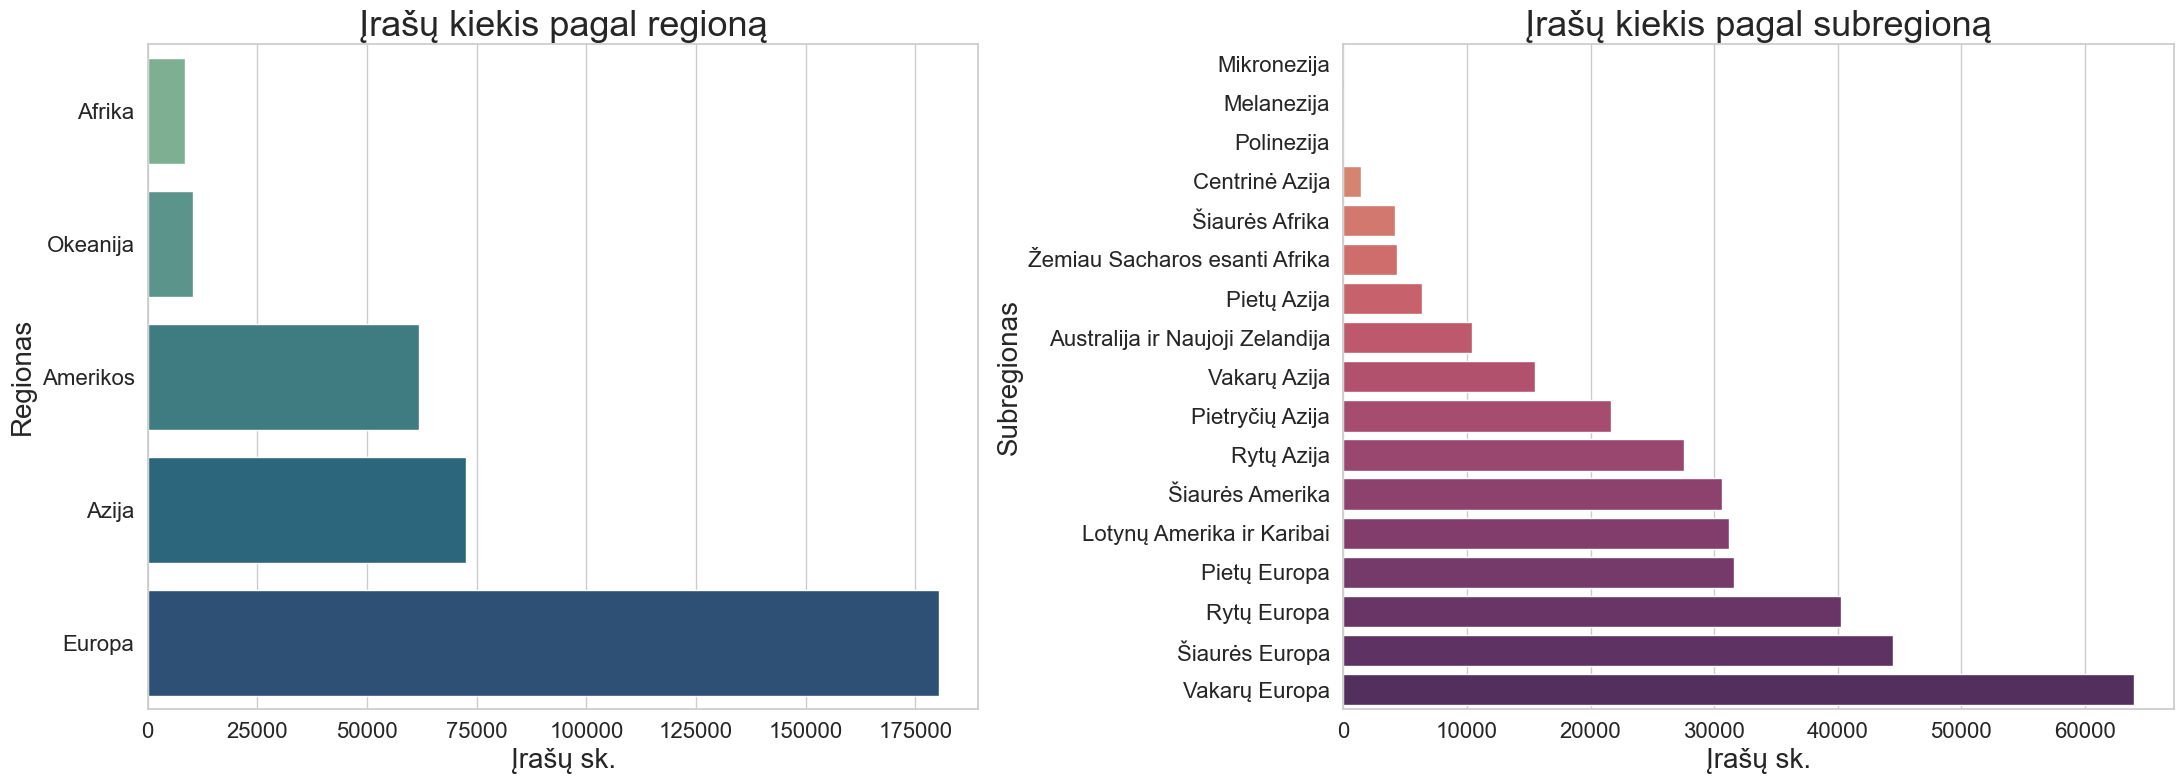

In [ ]:
def plot_region_subregion_counts(region_dfs, subregion_dfs):
    """
    Parodo stulpelines diagramas, kiek įrašų yra kiekviename regione ir subregione.
    
    Parametrai:
    - region_dfs: dict su regionų DataFrame'ais
    - subregion_dfs: dict su subregionų DataFrame'ais
    """

    region_counts = [(name, df.shape[0]) for name, df in region_dfs.items()]
    subregion_counts = [(name, df.shape[0]) for name, df in subregion_dfs.items()]

    region_df = pd.DataFrame(region_counts, columns=["Regionas", "Įrašų skaičius"])
    subregion_df = pd.DataFrame(subregion_counts, columns=["Sub-regionas", "Įrašų skaičius"])

    sns.set(style="whitegrid")

    fig, axes = plt.subplots(1, 2, figsize=(22, 8))

    # Regionų grafikas
    sns.barplot(y="Regionas", x="Įrašų skaičius", data=region_df.sort_values("Įrašų skaičius"), ax=axes[0], palette="crest")
    axes[0].set_title("Įrašų kiekis pagal regioną", fontsize=26)
    axes[0].set_xlabel("Įrašų skaičius", fontsize=20)
    axes[0].set_ylabel("Regionas", fontsize=20)
    axes[0].tick_params(axis='both', labelsize=16)

    # Subregionų grafikas
    sns.barplot(y="Sub-regionas", x="Įrašų skaičius", data=subregion_df.sort_values("Įrašų skaičius"), ax=axes[1], palette="crest")
    axes[1].set_title("Įrašų kiekis pagal sub-regioną", fontsize=26)
    axes[1].set_xlabel("Įrašų skaičius", fontsize=20)
    axes[1].set_ylabel("Sub-regionas", fontsize=20)
    axes[1].tick_params(axis='both', labelsize=16)

    plt.tight_layout()
    plt.show()

plot_region_subregion_counts(region_dfs_fasttext, subregion_dfs_fasttext)

**Klasterizavimui ir jo vaizdavimui naudojamos funkcijos**

In [ ]:
def k_cluster(df, field_name):
    """
    Perform clustering and t-SNE dimensionality reduction on embeddings.

    Parameters:
    - df: The input DataFrame.
    - field_name: The field to filter by for clustering.

    Returns:
    - df: DataFrame with added cluster labels and t-SNE coordinates.
    """
    df_filtered = df[df["field_name"] == field_name].copy()

    embedding_cols = [col for col in df_filtered.columns if col.startswith("emb")]
    X = df_filtered[embedding_cols].values

    X_scaled = StandardScaler().fit_transform(X)


    pca = PCA(n_components=50, random_state=42)
    X_pca = pca.fit_transform(X_scaled)

    tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
    X_tsne = tsne.fit_transform(X_pca)

    num_clusters = df_filtered["language_code"].nunique()
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    df_filtered["cluster"] = kmeans.fit_predict(X_scaled)

    df_filtered["tsne_x"] = X_tsne[:, 0]
    df_filtered["tsne_y"] = X_tsne[:, 1]

    return df_filtered

In [ ]:
def k_cluster_semi(df, field_name):
    """
    Semi-supervised clustering using known language codes.
    
    Parameters:
    - df: The input DataFrame.
    - field_name: The value to filter the 'field_name' column by.
    
    Returns:
    - df_filtered: DataFrame with cluster labels and t-SNE coordinates.
    """

    df_filtered = df[df["field_name"] == field_name].copy().reset_index(drop=True)

    embedding_cols = [col for col in df_filtered.columns if col.startswith("emb")]
    X = df_filtered[embedding_cols].values

    X_scaled = StandardScaler().fit_transform(X)

    X_pca = PCA(n_components=50, random_state=42).fit_transform(X_scaled)

    X_tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000).fit_transform(X_pca)

    language_codes = df_filtered["language_code"]
    known_labels = language_codes.dropna()
    known_indices = known_labels.index
    unique_langs = known_labels.unique()
    num_clusters = len(unique_langs)

    initial_centroids = []
    for lang in unique_langs:
        idxs = df_filtered[df_filtered["language_code"] == lang].index
        mean_vec = X_scaled[idxs].mean(axis=0)
        initial_centroids.append(mean_vec)
    initial_centroids = np.array(initial_centroids)

    kmeans = KMeans(n_clusters=num_clusters, init=initial_centroids, n_init=1, random_state=42)
    df_filtered["cluster"] = kmeans.fit_predict(X_scaled)

    df_filtered["tsne_x"] = X_tsne[:, 0]
    df_filtered["tsne_y"] = X_tsne[:, 1]

    return df_filtered


In [ ]:
def plot_k_cluster_panel(region_df, region_name="Šiaurės ir Pietų Amerikos"):
    """
    Nubraižo keturis t-SNE klasterizacijos grafikus vienoje panelėje pagal skirtingus laukus.
    
    Parametrai:
    - region_df: Duomenų rėmelis su regiono duomenimis
    - region_name: Pavadinimas, kuris bus naudojamas kaip bendras pavadinimas
    """

    field_names = ["description", "nutritional_info", "name", "breadcrumbs"]
    field_translations = {
        "description": "Aprašymas",
        "nutritional_info": "Maistinė informacija",
        "name": "Pavadinimas",
        "breadcrumbs": "Breadcrumbs"
    }

    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()

    for i, field_name in enumerate(field_names):
        df_filtered = k_cluster_semi(region_df, field_name)

        # Sukuriamas žemėlapis iš klasterio numerio į pradinę centroido kalbą
        unique_langs = df_filtered["language_code"].dropna().unique()
        cluster_language_map = {i: lang for i, lang in enumerate(unique_langs)}
        df_filtered["cluster_label"] = df_filtered["cluster"].map(
            lambda x: f"{x} ({cluster_language_map.get(x, 'nežinoma')})"
        )

        sns.scatterplot(
            x="tsne_x",
            y="tsne_y",
            hue="language_code",
            style="cluster_label",
            palette="tab20",
            data=df_filtered,
            alpha=0.7,
            s=60,
            ax=axes[i]
        )

        axes[i].set_title(f"{region_name} – {field_translations[field_name]}", fontsize=26)
        axes[i].set_xlabel("t-SNE X", fontsize=20)
        axes[i].set_ylabel("t-SNE Y", fontsize=20)
        axes[i].tick_params(axis='both', labelsize=20)
        axes[i].legend_.remove() 

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.02), fontsize=16)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()


C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
C:\Users\jurgi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\manifol

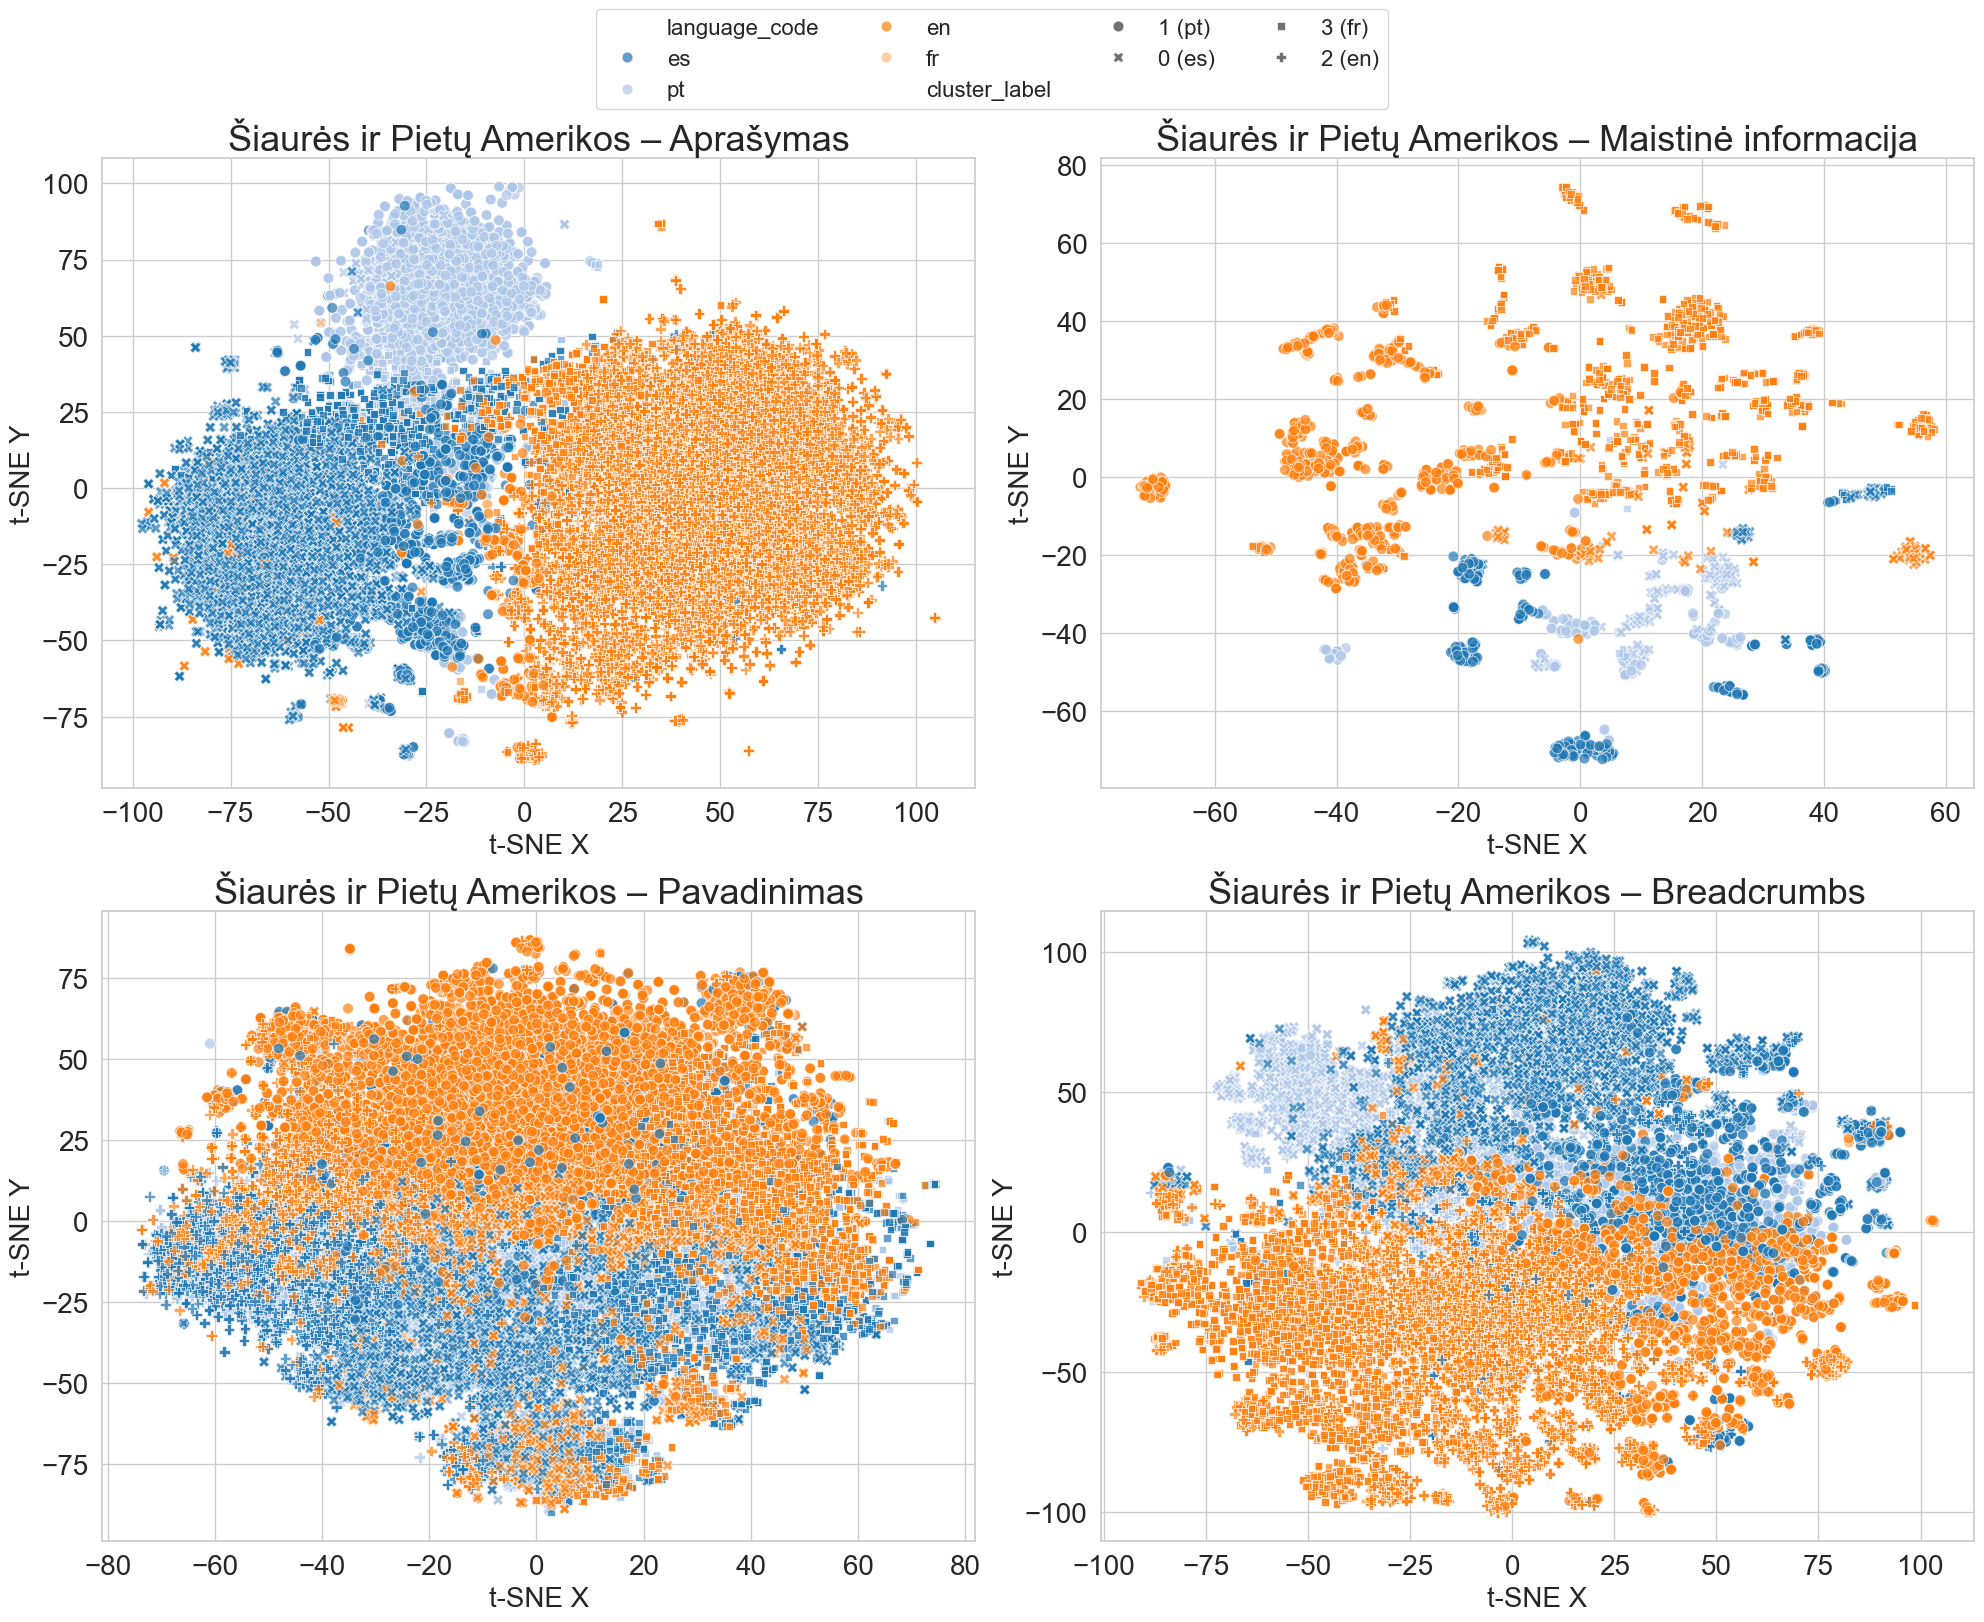

In [ ]:
plot_k_cluster_panel(region_dfs_fasttext["Amerikos"], "Šiaurės ir Pietų Amerikos")

**Hipotezių tikrinimas**

In [ ]:
#HipotezėDuom: daugumoje šalių yra viena dominuojanti kalba.
#H0: Daugumoje šalių nėra vienos aiškiai dominuojančios kalbos (populiariausios kalbos procentas yra mažesnis arba lygus 50%).
#H1: Daugumoje šalių yra viena dominuojanti kalba.

country_language_counts = df.groupby(['country_name', 'language_code']).size().reset_index(name='counts')

total_per_country = df.groupby('country_name').size().reset_index(name='total_counts')

country_language_counts = country_language_counts.merge(total_per_country, on='country_name')

country_language_counts['percent'] = (country_language_counts['counts'] / country_language_counts['total_counts']) * 100

dominant_languages = country_language_counts.loc[country_language_counts.groupby('country_name')['percent'].idxmax()]

dominant_languages['dominant'] = dominant_languages['percent'] > 50

num_countries = dominant_languages.shape[0]
num_dominant = dominant_languages['dominant'].sum()

print(f"Iš {num_countries} šalių, {num_dominant} turi vieną dominuojančią kalbą (virš 50% įrašų).")
print(f"Tai sudaro apie {(num_dominant / num_countries) * 100:.1f}% visų šalių.")

from scipy.stats import binomtest

result = binomtest(k=num_dominant, n=num_countries, p=0.5, alternative='greater')

print(f"Binominio testo p reikšmė: {result.pvalue}")

if result.pvalue < 0.05:
    print("Atmetame H0 - dauguma šalių turi dominuojančią kalbą.")
else:
    print("Negalime atmesti H0 - dauguma šalių neturi aiškios dominuojančios kalbos.")


Iš 80 šalių, 78 turi vieną dominuojančią kalbą (virš 50% įrašų).
Tai sudaro apie 97.5% visų šalių.
Binominio testo p reikšmė: 2.6808923652843627e-21
Atmetame H₀ – dauguma šalių turi dominuojančią kalbą.


In [128]:
df_combined_canada_clean_emb= pd.read_parquet("embedded_data_fasttext_Canada_clean_fp16.csv")
df_canada_ml = df_combined_canada_clean_emb.copy()

df_combined_lithuania_clean_emb = pd.read_parquet("embedded_data_fasttext_Lithuania_clean_fp16.csv")
df_binary_ml = df_combined_lithuania_clean_emb.copy()

df_binary_ml["label"] = df_binary_ml["label"].apply(lambda x: 1 if x == 2 else x)

lang_to_binary = {"lt": 1, "en": 0}
df_binary_ml["predicted_label"] = df_binary_ml["language_code"].map(lang_to_binary)

lang_to_binary = {"fr": 0, "en": 1}
df_canada_ml["predicted_label"] = df_canada_ml["language_code"].map(lang_to_binary)

In [149]:
df_all_new_method = pd.read_csv("language_predictions_lithuania_canada.csv")
df_all_new = df_all_new_method.copy()

df_lithuania_new_method = df_all_new[df_all_new["country_name"] == "Lithuania"]
df_canada_new_method = df_all_new[df_all_new["country_name"] == "Canada"]

df_lithuania_new_method["label"] = df_lithuania_new_method["label"].map({1: "lt", 0: "en"})
df_canada_new_method["label"] = df_canada_new_method["label"].map({1: "en", 0: "fr"})

df_lithuania_new = df_lithuania_new_method.copy()
df_canada_new = df_canada_new_method.copy()

print(df_lithuania_new)
print(df_canada_new)


     language_code language_code_predicted label   field_name country_name  \
0               lt                      lt    lt         name    Lithuania   
1               lt                      lt    lt         name    Lithuania   
2               lt               uncertain    en         name    Lithuania   
3               lt               uncertain    lt         name    Lithuania   
4               lt                      lt    lt         name    Lithuania   
...            ...                     ...   ...          ...          ...   
1495            lt                      lt    lt  description    Lithuania   
1496            lt                      lt    lt  description    Lithuania   
1497            lt                      lt    lt  description    Lithuania   
1498            lt                      lt    lt  description    Lithuania   
1499            lt                      lt    lt  description    Lithuania   

                                            field_value  retail

C:\Users\Dell\AppData\Local\Temp\ipykernel_14060\472962077.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Dell\AppData\Local\Temp\ipykernel_14060\472962077.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [133]:
#Hipotezė1: pavadinimai dažniau painiojami nei aprašymai (Lietuva, naujas)

from scipy.stats import ttest_ind

df_lithuania_new["correct"] = df_lithuania_new["language_code_predicted"] == df_lithuania_new["label"]

name_correct = df_lithuania_new[df_lithuania_new["field_name"] == "name"]["correct"]
desc_correct = df_lithuania_new[df_lithuania_new["field_name"] == "description"]["correct"]

name_errors = 1 - name_correct
desc_errors = 1 - desc_correct

# Atliekame dviejų imčių t-testą (vienpusį)
t_stat, p_value = ttest_ind(name_errors, desc_errors, alternative='greater')

print("Hipotezė: Pavadinimai dažniau nustatomi neteisingai nei aprašymai")
print(f"t statistika: {t_stat}")
print(f"p reikšmė: {p_value}")
if p_value < 0.05:
    print("Atmetame H0 - klaidų pavadinimuose daugiau nei aprašymuose.")
else:
    print("Neatmetame H0 - nėra reikšmingo skirtumo.")


Hipotezė: Pavadinimai dažniau nustatomi neteisingai nei aprašymai
t statistika: 6.831414578208781
p reikšmė: 7.746586406612149e-12
Atmetame H0 - klaidų pavadinimuose daugiau nei aprašymuose.


In [140]:
#Hipotezė1: pavadinimai dažniau painiojami nei aprašymai (Lietuva, senas)

df_lithuania_new["correct"] = df_lithuania_new["language_code"] == df_lithuania_new["label"]

name_correct = df_lithuania_new[df_lithuania_new["field_name"] == "name"]["correct"]
desc_correct = df_lithuania_new[df_lithuania_new["field_name"] == "description"]["correct"]

name_errors = 1 - name_correct
desc_errors = 1 - desc_correct

# Atliekame dviejų imčių t-testą (vienpusį)
t_stat, p_value = ttest_ind(name_errors, desc_errors, alternative='greater')

print("Hipotezė: Pavadinimai dažniau nustatomi neteisingai nei aprašymai")
print(f"t statistika: {t_stat}")
print(f"p reikšmė: {p_value}")
if p_value < 0.05:
    print("Atmetame H0 - klaidų pavadinimuose daugiau nei aprašymuose.")
else:
    print("Neatmetame H0 - nėra reikšmingo skirtumo.")

Hipotezė: Pavadinimai dažniau nustatomi neteisingai nei aprašymai
t statistika: 4.013523783559059
p reikšmė: 3.2403520201622644e-05
Atmetame H0 - klaidų pavadinimuose daugiau nei aprašymuose.


In [135]:
#Hipotezė1: pavadinimai dažniau painiojami nei aprašymai (Kanada, naujas)

df_canada_new["correct"] = df_canada_new["language_code_predicted"] == df_canada_new["label"]

name_correct = df_canada_new[df_canada_new["field_name"] == "name"]["correct"]
desc_correct = df_canada_new[df_canada_new["field_name"] == "description"]["correct"]

name_errors = 1 - name_correct
desc_errors = 1 - desc_correct

# Atliekame dviejų imčių t-testą (vienpusį)
t_stat, p_value = ttest_ind(name_errors, desc_errors, alternative='greater')

print("Hipotezė: Pavadinimai dažniau nustatomi neteisingai nei aprašymai")
print(f"t statistika: {t_stat}")
print(f"p reikšmė: {p_value}")
if p_value < 0.05:
    print("Atmetame H0 - klaidų pavadinimuose daugiau nei aprašymuose.")
else:
    print("Neatmetame H0 - nėra reikšmingo skirtumo.")


Hipotezė: Pavadinimai dažniau nustatomi neteisingai nei aprašymai
t statistika: 8.117135198002762
p reikšmė: 3.0808463885751747e-16
Atmetame H0 - klaidų pavadinimuose daugiau nei aprašymuose.


In [139]:
#Hipotezė1: pavadinimai dažniau painiojami nei aprašymai (Kanada, senas)

df_canada_new["correct"] = df_canada_new["language_code"] == df_canada_new["label"]

name_correct = df_canada_new[df_canada_new["field_name"] == "name"]["correct"]
desc_correct = df_canada_new[df_canada_new["field_name"] == "description"]["correct"]

name_errors = 1 - name_correct
desc_errors = 1 - desc_correct

# Atliekame dviejų imčių t-testą (vienpusį)
t_stat, p_value = ttest_ind(name_errors, desc_errors, alternative='greater')

print("Hipotezė: Pavadinimai dažniau nustatomi neteisingai nei aprašymai")
print(f"t statistika: {t_stat}")
print(f"p reikšmė: {p_value}")
if p_value < 0.05:
    print("Atmetame H0 - klaidų pavadinimuose daugiau nei aprašymuose.")
else:
    print("Neatmetame H0 - nėra reikšmingo skirtumo.")


Hipotezė: Pavadinimai dažniau nustatomi neteisingai nei aprašymai
t statistika: 8.604281920634696
p reikšmė: 5.292925371731545e-18
Atmetame H0 - klaidų pavadinimuose daugiau nei aprašymuose.


In [137]:
#Hipotezė2: Ilgesni tekstai rečiau supainiojami nei trumpesni (Lietuva, naujas)

df_lithuania_new["text_length"] = df_lithuania_new["field_value"].str.len()

df_lithuania_new["our_correct"] = df_lithuania_new["language_code_predicted"] == df_lithuania_new["label"]

correct_lengths = df_lithuania_new[df_lithuania_new["our_correct"] == True]["text_length"]
wrong_lengths = df_lithuania_new[df_lithuania_new["our_correct"] == False]["text_length"]

t_stat, p_value = ttest_ind(correct_lengths, wrong_lengths, alternative="greater")

print("Hipotezė: Ilgesni tekstai dažniau atpažįstami teisingai")
print(f"t statistika: {t_stat}")
print(f"p reikšmė: {p_value}")
print(f"Vidutinis ilgis (teisingi): {correct_lengths.mean():.1f} simbolių")
print(f"Vidutinis ilgis (neteisingi): {wrong_lengths.mean():.1f} simbolių")

if p_value < 0.05:
    print("Atmetame H0 - ilgesni tekstai tikrai dažniau atpažįstami teisingai Lietuvoje.")
else:
    print("Neatmetame H0 - reikšmingo skirtumo neaptikta Lietuvoje.")



Hipotezė: Ilgesni tekstai dažniau atpažįstami teisingai
t statistika: 4.203201196847599
p reikšmė: 1.3936153406069487e-05
Vidutinis ilgis (teisingi): 416.8 simbolių
Vidutinis ilgis (neteisingi): 109.6 simbolių
Atmetame H0 - ilgesni tekstai tikrai dažniau atpažįstami teisingai Lietuvoje.


In [138]:
#Hipotezė2: Ilgesni tekstai rečiau supainiojami nei trumpesni (Lietuva, senas)

df_lithuania_new["text_length"] = df_lithuania_new["field_value"].str.len()

df_lithuania_new["our_correct"] = df_lithuania_new["language_code"] == df_lithuania_new["label"]

correct_lengths = df_lithuania_new[df_lithuania_new["our_correct"] == True]["text_length"]
wrong_lengths = df_lithuania_new[df_lithuania_new["our_correct"] == False]["text_length"]

t_stat, p_value = ttest_ind(correct_lengths, wrong_lengths, alternative="greater")

print("Hipotezė: Ilgesni tekstai dažniau atpažįstami teisingai")
print(f"t statistika: {t_stat}")
print(f"p reikšmė: {p_value}")
print(f"Vidutinis ilgis (teisingi): {correct_lengths.mean():.1f} simbolių")
print(f"Vidutinis ilgis (neteisingi): {wrong_lengths.mean():.1f} simbolių")

if p_value < 0.05:
    print("Atmetame H0 - ilgesni tekstai tikrai dažniau atpažįstami teisingai Lietuvoje.")
else:
    print("Neatmetame H0 - reikšmingo skirtumo neaptikta Lietuvoje.")



Hipotezė: Ilgesni tekstai dažniau atpažįstami teisingai
t statistika: 6.88129950485423
p reikšmė: 4.344664801885285e-12
Vidutinis ilgis (teisingi): 457.0 simbolių
Vidutinis ilgis (neteisingi): 110.1 simbolių
Atmetame H0 - ilgesni tekstai tikrai dažniau atpažįstami teisingai Lietuvoje.


In [141]:
#Hipotezė2: Ilgesni tekstai rečiau supainiojami nei trumpesni (Kanada, naujas)

df_canada_new["text_length"] = df_canada_new["field_value"].str.len()

df_canada_new["our_correct"] = df_canada_new["language_code_predicted"] == df_canada_new["label"]

correct_lengths = df_canada_new[df_canada_new["our_correct"] == True]["text_length"]
wrong_lengths = df_canada_new[df_canada_new["our_correct"] == False]["text_length"]

t_stat, p_value = ttest_ind(correct_lengths, wrong_lengths, alternative="greater")

print("Hipotezė: Ilgesni tekstai dažniau atpažįstami teisingai")
print(f"t statistika: {t_stat}")
print(f"p reikšmė: {p_value}")
print(f"Vidutinis ilgis (teisingi): {correct_lengths.mean():.1f} simbolių")
print(f"Vidutinis ilgis (neteisingi): {wrong_lengths.mean():.1f} simbolių")

if p_value < 0.05:
    print("Atmetame H0 - ilgesni tekstai tikrai dažniau atpažįstami teisingai Kanadoje.")
else:
    print("Neatmetame H0 - reikšmingo skirtumo neaptikta Kanadoje.")

Hipotezė: Ilgesni tekstai dažniau atpažįstami teisingai
t statistika: 4.96735107288502
p reikšmė: 3.4780751714582216e-07
Vidutinis ilgis (teisingi): 450.7 simbolių
Vidutinis ilgis (neteisingi): 138.6 simbolių
Atmetame H0 - ilgesni tekstai tikrai dažniau atpažįstami teisingai Kanadoje.


In [142]:
#Hipotezė2: Ilgesni tekstai rečiau supainiojami nei trumpesni (Kanada, senas)

df_canada_new["text_length"] = df_canada_new["field_value"].str.len()

df_canada_new["our_correct"] = df_canada_new["language_code"] == df_canada_new["label"]

correct_lengths = df_canada_new[df_canada_new["our_correct"] == True]["text_length"]
wrong_lengths = df_canada_new[df_canada_new["our_correct"] == False]["text_length"]

t_stat, p_value = ttest_ind(correct_lengths, wrong_lengths, alternative="greater")

print("Hipotezė: Ilgesni tekstai dažniau atpažįstami teisingai")
print(f"t statistika: {t_stat}")
print(f"p reikšmė: {p_value}")
print(f"Vidutinis ilgis (teisingi): {correct_lengths.mean():.1f} simbolių")
print(f"Vidutinis ilgis (neteisingi): {wrong_lengths.mean():.1f} simbolių")

if p_value < 0.05:
    print("Atmetame H0 - ilgesni tekstai tikrai dažniau atpažįstami teisingai Kanadoje.")
else:
    print("Neatmetame H0 - reikšmingo skirtumo neaptikta Kanadoje.")

Hipotezė: Ilgesni tekstai dažniau atpažįstami teisingai
t statistika: 5.36038258311106
p reikšmė: 4.2914017166061026e-08
Vidutinis ilgis (teisingi): 455.7 simbolių
Vidutinis ilgis (neteisingi): 175.6 simbolių
Atmetame H0 - ilgesni tekstai tikrai dažniau atpažįstami teisingai Kanadoje.


In [143]:
# H3: Metodo tikslumas su Lietuvos duomenimis statistiškai reikšmingai skiriasi nuo metodo tikslumo su Kanados duomenimis. Skirtumas turėtų būti statistiškai reikšmingai, nes Kanados duomenų yra daugiau ir ant jų nenaudojome klasterizavimo, todėl tikslumas turėtų būti žemesnis.
import pandas as pd
from scipy.stats import chi2_contingency

# Naujas metodas
# H0: Metodo tikslumas Kanados ir Lietuvos duomenyse nesiskiria. Kitaip tariant, tikslumo skirtumas yra atsitiktinis.
# H1: Metodo tikslumas su Lietuvos duomenimis statistiškai reikšmingai skiriasi nei su Kanados duomenimis.


df_lithuania_certain = df_lithuania_new[df_lithuania_new["language_code_predicted"] != "uncertain"].copy()
df_canada_certain = df_canada_new[df_canada_new["language_code_predicted"] != "uncertain"].copy()

df_lithuania_certain['correct'] = df_lithuania_certain['language_code_predicted'] == df_lithuania_certain['label']
df_canada_certain['correct'] = df_canada_certain['language_code_predicted'] == df_canada_certain['label']

lithuania_counts = df_lithuania_certain['correct'].value_counts().reindex([True, False], fill_value=0)
canada_counts = df_canada_certain['correct'].value_counts().reindex([True, False], fill_value=0)

acc_lithuania = lithuania_counts[True] / lithuania_counts.sum()
acc_canada = canada_counts[True] / canada_counts.sum()

print(f"Lithuania accuracy: {acc_lithuania:.4f}")
print(f"Canada accuracy: {acc_canada:.4f}")

contingency_table = pd.DataFrame({
    'Lithuania': lithuania_counts,
    'Canada': canada_counts
}).T  

print("Contingency table (country vs correctness):")
print(contingency_table)

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square test result: chi2 = {chi2}, p-value = {p}")
if p < 0.05:
    print("Atmetame H0 - skirtumas statistiškai reikšmingas.")
else:
    print("Negalime atmesti H0 - nėra statistiškai reikšmingo skirtumo tarp tikslumų.")


Lithuania accuracy: 0.9597
Canada accuracy: 0.9798
Contingency table (country vs correctness):
correct    True   False
Lithuania   1380     58
Canada      6346    131

Chi-square test result: chi2 = 19.560100141783884, p-value = 9.748398323786417e-06
Atmetame H0 - skirtumas statistiškai reikšmingas.


In [ ]:
# H3: Metodo tikslumas su Lietuvos duomenimis statistiškai reikšmingai skiriasi nuo metodo tikslumo su Kanados duomenimis.

# Senas metodas
# H0: Metodo tikslumas Kanados ir Lietuvos duomenyse nesiskiria. Kitaip tariant, tikslumo skirtumas yra atsitiktinis.
# H1: Metodo tikslumas su Lietuvos duomenimis statistiškai reikšmingai skiriasi nuo su Kanados duomenimis gautu tikslumu.


df_lithuania_new['correct'] = df_lithuania_new['language_code'] == df_lithuania_new['label']
df_canada_new['correct'] = df_canada_new['language_code'] == df_canada_new['label']

lithuania_counts = df_lithuania_new['correct'].value_counts().reindex([True, False], fill_value=0)
canada_counts = df_canada_new['correct'].value_counts().reindex([True, False], fill_value=0)

acc_lithuania = lithuania_counts[True] / lithuania_counts.sum()
acc_canada = canada_counts[True] / canada_counts.sum()

print(f"Lithuania accuracy: {acc_lithuania:.4f}")
print(f"Canada accuracy: {acc_canada:.4f}")

contingency_table = pd.DataFrame({
    'Lithuania': lithuania_counts,
    'Canada': canada_counts
}).T  


print("Contingency table (country vs correctness):")
print(contingency_table)

# Perform Chi-square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square test result: chi2 = {chi2}, p-value = {p}")
if p < 0.05:
    print("Atmetame H0 - skirtumas statistiškai reikšmingas.")
else:
    print("Negalime atmesti H0 - nėra statistiškai reikšmingo skirtumo tarp tikslumų.")


Lithuania accuracy: 0.8133
Canada accuracy: 0.9266
Contingency table (country vs correctness):
correct    True   False
Lithuania   1220    280
Canada      6187    490

Chi-square test result: chi2 = 182.9395171709857, p-value = 1.1056877648172395e-41
Atmetame H0 - skirtumas statistiškai reikšmingas.


In [146]:
#Hipotezė4: Naujo metodo tikslumas su Kanados ir Lietuvos duomenimis statistiškai reikšmingai didesnis negu senojo metodo tikslumas.

#H0: Naujo metodo tikslumas yra lygus senojo metodo tikslumui (arba nėra reikšmingo skirtumo).
#H1: Naujo metodo tikslumas statistiškai reikšmingai skiriasi nuo senojo metodo tikslumo.

df_lithuania_certain = df_lithuania_new[df_lithuania_new["language_code_predicted"] != "uncertain"].copy()
df_canada_certain = df_canada_new[df_canada_new["language_code_predicted"] != "uncertain"].copy()

def method_accuracy_test(df, country_name):
    df_old = df.copy()
    df_old['correct'] = df_old['language_code'] == df_old['label']
    
    df_new = df.copy()
    df_new['correct'] = df_new['language_code_predicted'] == df_new['label']
    
    old_counts = df_old['correct'].value_counts().reindex([True, False], fill_value=0)
    new_counts = df_new['correct'].value_counts().reindex([True, False], fill_value=0)

    contingency_table = pd.DataFrame({
        'Correct': [old_counts[True], new_counts[True]],
        'Incorrect': [old_counts[False], new_counts[False]]
    }, index=['Old method', 'New method'])
    
    print(f"\nLentelė {country_name} duomenims (metodas vs teisingumas):")
    print(contingency_table)
    
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    acc_old = old_counts[True] / old_counts.sum()
    acc_new = new_counts[True] / new_counts.sum()
    
    print(f"\n{country_name} - Senasis metodas tikslumas: {acc_old}")
    print(f"{country_name} - Naujas metodas tikslumas: {acc_new}")
    print(f"Chi-square test result: chi2 = {chi2}, p-value = {p}")
    
    if p < 0.05:
        if acc_new > acc_old:
            print("Atmetame H0 - naujo metodo tikslumas yra statistiškai reikšmingai didesnis.")
        else:
            print("Atmetame H0 - seno metodo tikslumas yra statistiškai reikšmingai didesnis.")
    else:
        print("Negalime atmesti H0 - nėra statistiškai reikšmingo skirtumo tarp metodų.")


method_accuracy_test(df_lithuania_certain, "Lietuvos")

method_accuracy_test(df_canada_certain, "Kanados")



Lentelė Lietuvos duomenims (metodas vs teisingumas):
            Correct  Incorrect
Old method     1171        267
New method     1380         58

Lietuvos - Senasis metodas tikslumas: 0.8143254520166898
Lietuvos - Naujas metodas tikslumas: 0.9596662030598053
Chi-square test result: chi2 = 150.07962367698943, p-value = 1.6655432737741759e-34
Atmetame H0 - naujo metodo tikslumas yra statistiškai reikšmingai didesnis.

Lentelė Kanados duomenims (metodas vs teisingumas):
            Correct  Incorrect
Old method     6008        469
New method     6346        131

Kanados - Senasis metodas tikslumas: 0.9275899336112398
Kanados - Naujas metodas tikslumas: 0.9797745870001544
Chi-square test result: chi2 = 198.4745596567913, p-value = 4.494934299133163e-45
Atmetame H0 - naujo metodo tikslumas yra statistiškai reikšmingai didesnis.


In [147]:
#Hipotezė5: Naujo metodo priskirtos kalbos statistiškai reikšmingai skiriasi nuo kalbų priskirtų senuoju būdu.

#H0: Naujo metodo priskirtos kalbos yra tokios pačios kaip ir senojo metodo priskirtos kalbos (arba nėra reikšmingo skirtumo).
#H1: Naujo metodo prognozės statistiškai reikšmingai skiriasi nuo senųjų prognozių.

df_lithuania_certain = df_lithuania_new[df_lithuania_new["language_code_predicted"] != "uncertain"].copy()
df_canada_certain = df_canada_new[df_canada_new["language_code_predicted"] != "uncertain"].copy()

df_combined = pd.concat([df_lithuania_certain, df_canada_certain], ignore_index=True)
contingency_table = pd.crosstab(df_combined['language_code'], df_combined['language_code_predicted'])

print("Kryžminė lentelė: senasis vs naujasis prognozių pasiskirstymas")
print(contingency_table)

chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nChi-square test result: chi2 = {chi2}, p-value = {p}")

if p < 0.05:
    print("Atmetame H0 - naujos prognozės statistiškai reikšmingai skiriasi nuo senųjų.")
else:
    print("Negalime atmesti H0 - nėra statistiškai reikšmingo skirtumo tarp naujų ir senų prognozių.")


Kryžminė lentelė: senasis vs naujasis prognozių pasiskirstymas
language_code_predicted  bs  de    en   fr  hu  it  la    lt  pl
language_code                                                   
en                        1   2  5883  292   1   2   0     0   1
fr                        0   0   237   58   0   0   0     0   0
lt                        0   0   224    0   0   1   1  1211   1

Chi-square test result: chi2 = 6603.822287447129, p-value = 0.0
Atmetame H0 - naujos prognozės statistiškai reikšmingai skiriasi nuo senųjų.
